(6, 784)


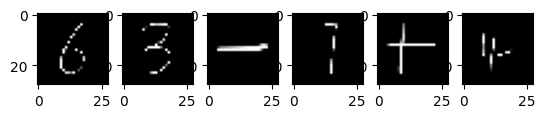

In [25]:
import matplotlib.pyplot as plt
import queue
import cv2
import numpy as np

def get_x_y_cuts(data, n_lines=1):
    #传入二值化后的图像进行联通域分割
    # 获取图像尺寸
    w, h = data.shape
    # 定义一个集合来保存已访问过的像素
    visited = set()
    # 创建一个队列，用于广度优先搜索（BFS）
    q = queue.Queue()
    # 定义邻接像素的位移（8个方向）
    offset = [(-1, -1), (0, -1), (1, -1), (-1, 0), (1, 0), (-1, 1), (0, 1), (1, 1)]
    # 定义一个列表来保存每个字符的边界位置
    cuts = []
    x, y = np.where(data<200)
    for xi, yi in zip(x, y):
        x_axis = []
        y_axis = []
        if (xi, yi) not in visited:
            q.put((xi, yi))
            visited.add((xi, yi))
        while not q.empty():
            x_p, y_p = q.get()
            for x_offset, y_offset in offset:
                x_c, y_c = x_p + x_offset, y_p + y_offset
                if (x_c, y_c) in visited:
                    continue
                visited.add((x_c, y_c))
                try:
                    if data[x_c][y_c] <200:
                        q.put((x_c, y_c))
                        x_axis.append(x_c)
                        y_axis.append(y_c)
                except:
                    pass
            # 如果坐标列表不为空，那么就计算当前字符的边界，并保存到cuts列表中
            if x_axis:
                min_x, max_x = min(x_axis), max(x_axis)
                min_y, max_y = min(y_axis), max(y_axis)
                if max_x - min_x > 2 or max_y - min_y > 2:
                    cuts.append([min_x, max_x + 1, min_y, max_y + 1])
                # cuts.append([min_x, max_x + 1, min_y, max_y + 1])
    # 将cuts列表中的边界按照y坐标排序，这样做是为了按照字符的读取顺序（从左到右）来处理字符
    if n_lines == 1:
        cuts = sorted(cuts, key=lambda x: x[2])
        pr_item = cuts[0]
        count = 1
        len_cuts = len(cuts)
        new_cuts = [cuts[0]]
        pr_k = 0
        for i in range(1, len_cuts):
            pr_item = new_cuts[pr_k]
            now_item = cuts[i]
            if not (now_item[2] > pr_item[3]):
                new_cuts[pr_k][0] = min(pr_item[0], now_item[0])
                new_cuts[pr_k][1] = max(pr_item[1], now_item[1])
                new_cuts[pr_k][2] = min(pr_item[2], now_item[2])
                new_cuts[pr_k][3] = max(pr_item[3], now_item[3])
            else:
                new_cuts.append(now_item)
                pr_k += 1
        cuts = new_cuts
    return cuts
 
def get_image_cuts(image, dir=None, is_data=False, n_lines=1, data_needed=False, count=0):
    if isinstance(image, str):
        data = cv2.imread(image, 2)
    else:
        data = image
    # 获取每个字符的边界
    cuts = get_x_y_cuts(data, n_lines=n_lines)
    # 定义一个变量来保存所有字符的图像数据
    image_cuts = None
    # 遍历每个字符的边界，然后裁剪和缩放图像，最后保存到文件或添加到图像数据列表中
    for i, item in enumerate(cuts):
        count += 1
        max_dim = max(item[1] - item[0], item[3] - item[2])
        new_data = np.ones((int(1.4 * max_dim), int(1.4 * max_dim))) * 255
        x_min, x_max = (max_dim - item[1] + item[0]) // 2, (max_dim - item[1] + item[0]) // 2 + item[1] - item[0]
        y_min, y_max = (max_dim - item[3] + item[2]) // 2, (max_dim - item[3] + item[2]) // 2 + item[3] - item[2]
        new_data[int(0.2 * max_dim) + x_min:int(0.2 * max_dim) + x_max, int(0.2 * max_dim) + y_min:int(0.2 * max_dim) + y_max] = data[item[0]:item[1], item[2]:item[3]]
        standard_data = cv2.resize(new_data, (28, 28))
        if not data_needed:
            cv2.imwrite(dir + str(count) + ".jpg", standard_data)
        if data_needed:
            data_flat = (255 - np.resize(standard_data, (1, 28 * 28))) / 255
            if image_cuts is None:
                image_cuts = data_flat
            else:
                image_cuts = np.r_[image_cuts, data_flat]
    if data_needed:
        # 如果需要返回图像数据，那么就返回
        return image_cuts
    return count

#读取四则运算的图片
img = cv2.imread('./test/86.png', cv2.IMREAD_GRAYSCALE)

#获取切割后的图片
img_cuts = get_image_cuts(img, dir=None, is_data=False, n_lines=1, data_needed=True, count=0)
print(img_cuts.shape)
for i in range(img_cuts.shape[0]):
    plt.subplot(1, 6, i+1)
    plt.imshow(img_cuts[i].reshape(28, 28), cmap='gray')

In [8]:
def calculate(equation):
    OPERATORS = {'add': '+', 'sub': '-', 'mul': '*', 'div': '/'}
    # Transform equation to infix notation
    infix = []
    for item in equation:
        if item in OPERATORS:
            infix.append(OPERATORS[item])
        elif item == 'left':
            infix.append('(')
        elif item == 'right':
            infix.append(')')
        else:
            infix.append(item)
    infix_equation = ''.join(infix)

    # Evaluate the expression
    result = eval(infix_equation)

    return result, infix_equation

equation = ['1', 'mul', '2', 'add', 'left','4','sub', '2','right']
result, infix_equation = calculate(equation)
print(infix_equation, '=', result)


1*2+(4-2) = 4
